# 5. ADI forward modeling of point sources

> Authors: *Valentin Christiaens* and *Carlos Alberto Gomez Gonzalez*  
> Suitable for VIP *v1.0.0* onwards  
> Last update: *2022/03/23*

**Table of contents**

* [5.1. Loading ADI data](#1.-Loading-ADI-data)

* [5.2. Generating and injecting synthetic planets](#5.2.-Generating-and-injecting-synthetic-planets)
 
* [5.3. Flux and position estimation with NEGFC](#5.3.-Flux-and-position-estimation-with-NEGFC)
    - [5.3.1. Nelder-Mead based optimization](#5.3.1.-Nelder-Mead-based-optimization)
    - [5.3.2. Planet subtraction](#5.3.2.-Planet-subtraction)
    - [5.3.3. NEGFC technique coupled with MCMC](#5.3.3.-NEGFC-technique-coupled-with-MCMC)
        - [5.3.3.1. Running the MCMC sampler](#5.3.3.1.-Running-the-MCMC-sampler)
        - [5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots](#5.3.3.2.-Visualizing-the-MCMC-chain:-corner-plots-and-walk-plots)
        - [5.3.3.3. Highly probable values and confidence intervals](#5.3.3.3.-Highly-probable-values-and-confidence-intervals)
    - [5.3.4. Residual speckle uncertainty](#5.3.4.-Residual-speckle-uncertainty)
    - [5.3.5. Final uncertainties](#5.3.5.-Final-uncertainties)

This tutorial shows:

- how to generate and inject fake companions in a cube;
- how to estimate the astrometry and photometry of a directly imaged companion, and associated uncertainties.

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we import all the VIP routines that will be used in this tutorial.
The path to some routines has changed between versions 1.0.3 and 1.1.0, which saw a major revamp of the modular architecture, hence the `if` statements.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import VLT_NACO
    from vip_hci.metrics import cube_inject_companions
    from vip_hci.negfc import (confidence, firstguess, mcmc_negfc_sampling, show_corner_plot, show_walk_plot,
                               speckle_noise_uncertainty)
    from vip_hci.pca import pca, pca_annular, pca_annulus, pca_grid
else:
    from vip_hci.config import VLT_NACO
    from vip_hci.fm import (confidence, cube_inject_companions, cube_planet_free, firstguess, mcmc_negfc_sampling, 
                            normalize_psf, show_corner_plot, show_walk_plot, speckle_noise_uncertainty)
    from vip_hci.psfsub import median_sub, pca, pca_annular, pca_annulus, pca_grid
    
# common to all versions:
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import contrast_curve, detection, significance, snr, snrmap, throughput
from vip_hci.preproc import frame_crop
from vip_hci.var import fit_2dgaussian, frame_center

VIP version:  1.2.2


## 5.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO coronagraphic (VORTEX AGPM) dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract). The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the data:

In [3]:
psfnaco = '../datasets/naco_betapic_psf.fits'
cubename = '../datasets/naco_betapic_cube_cen.fits'
angname = '../datasets/naco_betapic_pa.fits'

cube = open_fits(cubename)
psf = open_fits(psfnaco)
pa = open_fits(angname)

Fits HDU-0 data successfully loaded. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)
Fits HDU-0 data successfully loaded. Data shape: (61,)


In [4]:
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)

angs = pa+derot_off+TN

Let's measure the FWHM by fitting a 2D Gaussian to the core of the unsaturated non-coronagraphic PSF:

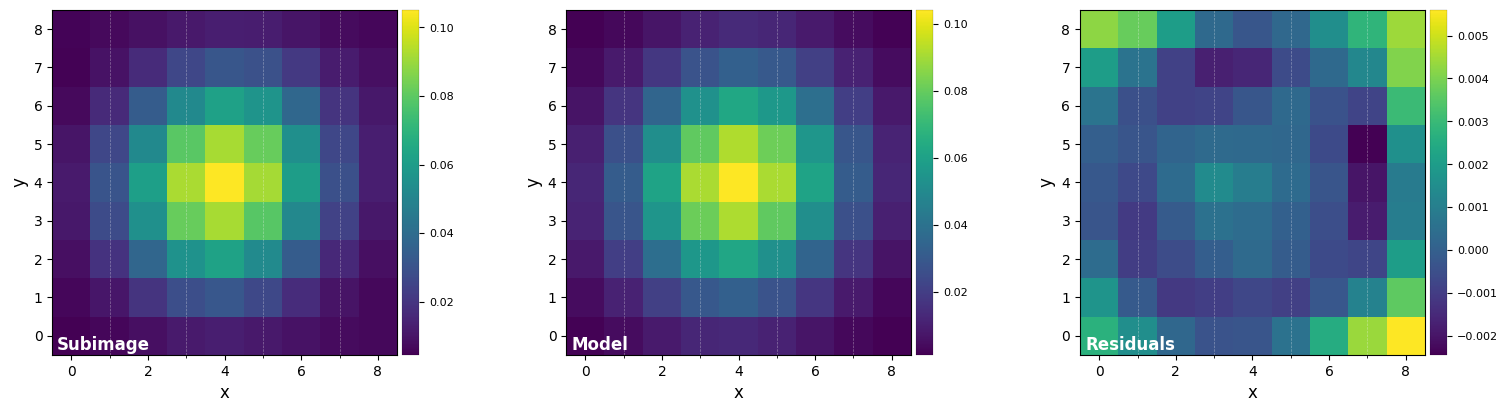

FWHM_y = 4.733218722257407
FWHM_x = 4.473682405059958 

centroid y = 19.006680059041216
centroid x = 18.999424475165455
centroid y subim = 4.006680059041214
centroid x subim = 3.9994244751654535 

amplitude = 0.10413004853269707
theta = -34.08563676836685


In [5]:
%matplotlib inline
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [6]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.603450563658683


Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array:

In [7]:
psfn = normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


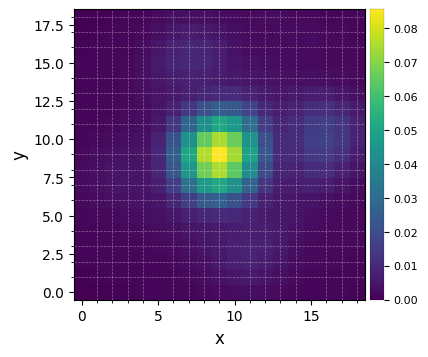

In [8]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `config` subpackage:

In [9]:
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


## 5.2. Generating and injecting synthetic planets

We first select `imlib` and associated `interpolation` order. 'vip-fft' is more accurate, but 'skimage' is faster, and 'opencv' even faster - see `Tutorial 7`. `opencv` should now be installed by default with VIP, but this was not the case in past versions. If you don't have it and don't want to install it (`pip install opencv-python`), use `skimage`:

In [10]:
imlib_rot = 'opencv' #'skimage'
interpolation='lanczos4' #'biquintic'   

The `cube_inject_companions` function in the `fm` module (VIP versions >= 1.1.0) makes the injection of fake companions at arbitrary fluxes and locations very easy. The normalized non-coronagraphic PSF should be provided for the injection. If the user does not have access to an observed PSF, the `create_synth_psf` from the `var` module can be used to create synthetic ones (based on 2D Gaussian, Moffat or Airy models).

Some procedures, e.g. the negative fake companion technique and the contrast curve generation, heavily rely on the injection of fake companions. The coordinates for the injection are provided in the *derotated* image, while the actual injection occurs in the images of the input cube, i.e. in the *rotated* field.

In [11]:
rad_fc = 30.5
theta_fc = 240
flux_fc = 400.

gt = [rad_fc, theta_fc, flux_fc]

In [12]:
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=flux_fc, plsc=pxscale_naco, 
                                rad_dists=[rad_fc], theta=theta_fc, n_branches=1, 
                                imlib=imlib_rot, interpolation=interpolation)


Let's set the corresponding cartesian coordinates:

In [13]:
cy, cx = frame_center(cube[0])
x_fc = cx + rad_fc*np.cos(np.deg2rad(theta_fc))
y_fc = cy + rad_fc*np.sin(np.deg2rad(theta_fc))

xy_test = (x_fc, y_fc)
print('({:.1f}, {:.1f})'.format(xy_test[0],xy_test[1]))

(34.7, 23.6)


Let's double-check the fake companion was injected at the right location, by post-processing the cube and checking the final image. Let's use PCA, and infer the optimal $n_{\rm pc}$ while we are at it - this will be useful for the next section.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-28 00:32:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.052761
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 41
Optimal number of PCs = 10, for S/N=13.415
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 34.7, 23.6
Flux in a centered 1xFWHM circular aperture = 104.785
Central pixel S/N = 18.264
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 13.415
Max S/N (shifting the aperture center) = 18.472
stddev S/N (shifting the aperture center) = 4.088



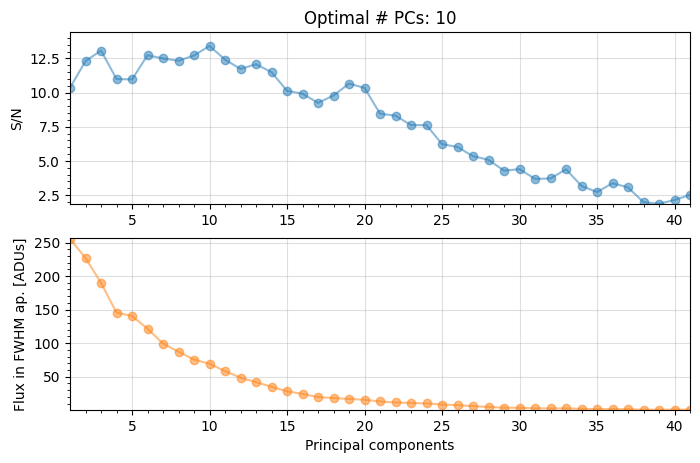

In [14]:
res_ann_opt = pca_grid(cubefc, angs, fwhm=fwhm_naco, range_pcs=(1,41,1), source_xy=xy_test, mode='annular',
                       annulus_width=4*fwhm_naco, imlib=imlib_rot, interpolation=interpolation, 
                       full_output=True, plot=True)

The grid search looking for the optimal number of principal components (npc) found that 10 principal components maximizes the S/N ratio of the injected fake companion. 

In [15]:
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

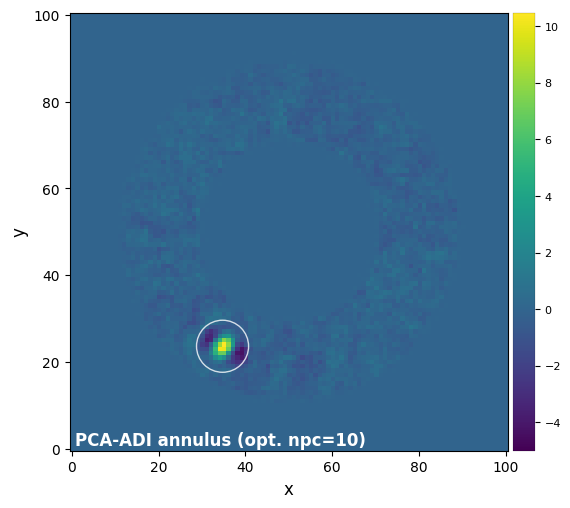

In [16]:
plot_frames(final_ann_opt, label='PCA-ADI annulus (opt. npc={:.0f})'.format(opt_npc_ann),
            dpi=100, vmin=-5, colorbar=True, circle=xy_test)

We can see that the fake companion was indeed injected at the requested location.

## 5.3. Flux and position estimation with NEGFC

When a companion candidate is detected, the next step is to characterize it, i.e. infer its exact position (astrometry) and flux (photometry). 

<font color=orange> **Question 5.1**: Why would a simple 2D Gaussian fit (as performed e.g. for the stellar PSF in Section 5.1) be inappropriate to extract the astrometry and photometry of a candidate companion? </font>

`VIP` implements the Negative fake companion (NEGFC) technique for robust extraction of the position and flux of detected point-like sources. The technique can be summarized as follow (see full description in [Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract)):

1) Estimate the position and flux of the planet, from either the visual inspection of reduced images or a previous estimator (see ABC below).

2) Scale (in flux) and shift the normalized off-axis PSF to remove the estimate from the input data cube.

3) Process the cube with PCA in a single annulus encompassing the point source.

4) Measure residuals in an aperture centered on the approximate location of the companion candidate.

5) Iterate on the position and flux of the injected negative PSF (steps 2-4), until the absolute residuals in the aperture are minimized (i.e. the injected negative companion flux and the position match exactly that of the true companion).

Iterations between steps 2-4 can be performed in one of 3 ways - sorted in increasing computation time and accuracy: 

A) a grid search on the flux only, provided a fixed estimate of the position (implemented in the `firstguess` function);

B) a Nelder-Mead simplex algorithm (`firstguess` function with the `simplex=True` option);

C) an MCMC sampler, which has the advantage to also yield uncertainties on each of the parameters of the point source (`mcmc_negfc_sampling` function).

Different figures of merit can be used for minimization of the residuals ([Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract); [Christiaens et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.6117C/abstract)):
$$\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}~~({\rm default}), ~~~~~~~~\chi^2 = \sum_j^N |I_j|, ~~~~~~~~\chi^2 = N {\rm std}(I_j).$$

where $j \in {1,...,N}$, $N$ is the total number of pixels contained in the circular aperture around the companion candidate, $\mu$ and $\sigma$ are the mean and standard deviation ($N_{\rm resel}$ degrees of freedom) of pixel intensities in a truncated annulus at the radius of the companion candidate, but avoiding the azimuthal region encompassing the negative side lobes.

### 5.3.1. Nelder-Mead based optimization

With the function `firstguess`, we can obtain a first estimation of the flux and position by running A) a naive grid minimization (grid of values for the flux through parameter `f_range`), and B) a Nelder-mead based minimization (if the parameter `simplex` is set to *True*). The latter is done based on the preliminary guess of the grid minimization. The maximum number of iterations and error can be set with the parameter `simplex_options` as a dicitionary (see `scipy.minimize` function for the Nelder-Mead options).

Fisrt we define the position of the sources by examining a flux frame or S/N map. `planets_xy_coord` takes a list or array of X,Y pairs like ((x1,y1),(x2,y2)...(x_n,y_n)). Let's take the coordinates of the previously injected companion.

Let's test the algorithm with different values for the # of PCs: 5 and 25.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-28 00:32:36
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   1.975
2/30   0.149   1.974
3/30   0.221   1.974
4/30   0.329   1.972
5/30   0.489   1.971
6/30   0.728   1.969
7/30   1.083   1.965
8/30   1.610   1.960
9/30   2.395   1.953
10/30   3.562   1.942
11/30   5.298   1.926
12/30   7.880   1.902
13/30   11.721   1.866
14/30   17.433   1.813
15/30   25.929   1.733
16/30   38.566   1.615
17/30   57.362   1.446
18/30   85.317   1.216
19/30   126.896   0.926
20/30   188.739   0.554
21/30   280.722   0.179
22/30   417.532   0.047


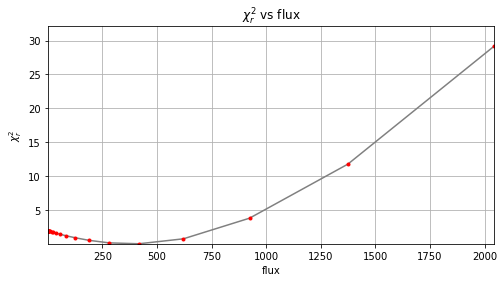

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 97, nfev: 224, chi2r: 0.030578838959905028
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.535, 239.976, 383.055) at 
          (X,Y)=(34.72, 23.56)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:16.243705
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [17]:
r_lo, theta_lo, f_lo = firstguess(cubefc, angs, psfn, ncomp=5, planets_xy_coord=[xy_test], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, simplex=True, imlib=imlib_rot, 
                                  interpolation=interpolation, plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-28 00:32:53
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   0.295
2/30   0.149   0.295
3/30   0.221   0.295
4/30   0.329   0.295
5/30   0.489   0.295
6/30   0.728   0.295
7/30   1.083   0.295
8/30   1.610   0.295
9/30   2.395   0.295
10/30   3.562   0.294
11/30   5.298   0.293
12/30   7.880   0.292
13/30   11.721   0.291
14/30   17.433   0.290
15/30   25.929   0.286
16/30   38.566   0.283
17/30   57.362   0.275
18/30   85.317   0.249
19/30   126.896   0.223
20/30   188.739   0.180
21/30   280.722   0.107
22/30   417.532   0.058


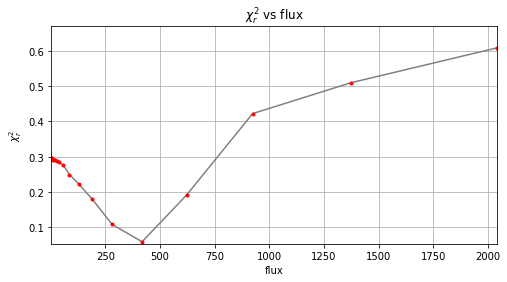

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 71, nfev: 186, chi2r: 0.05277664606807796
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.186, 239.897, 424.156) at 
          (X,Y)=(34.86, 23.89)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:14.645611
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [18]:
r_hi, theta_hi, f_hi = firstguess(cubefc, angs, psfn, ncomp=25, planets_xy_coord=[xy_test], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                                  simplex=True, plot=True, verbose=True)

For both the $n_{\rm pc} = 5$ and $n_{\rm pc} = 25$ cases, the parameters estimated by the Nelder-Mead optimization are not exactly equal to the original values (radius=30.5, theta=240, flux=400), which reflects:

- the limitations of this heuristic minization procedure (depending on the initial guess the minimization may get trapped in a different local minimum);
- the higher residual speckle noise level in images obtained with low $n_{\rm pc}$ values; 
- the higher self-subtraction for high $n_{\rm pc}$ values.

These estimates are provided without uncertainties (error bars). We will come back to this question later on. 

For comparison, let's use the optimal $n_{\rm pc} = 10$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-28 00:33:07
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   1.992
2/30   0.149   1.992
3/30   0.221   1.991
4/30   0.329   1.990
5/30   0.489   1.989
6/30   0.728   1.987
7/30   1.083   1.984
8/30   1.610   1.980
9/30   2.395   1.974
10/30   3.562   1.964
11/30   5.298   1.951
12/30   7.880   1.931
13/30   11.721   1.900
14/30   17.433   1.855
15/30   25.929   1.785
16/30   38.566   1.696
17/30   57.362   1.554
18/30   85.317   1.315
19/30   126.896   1.031
20/30   188.739   0.650
21/30   280.722   0.224
22/30   417.532   0.056


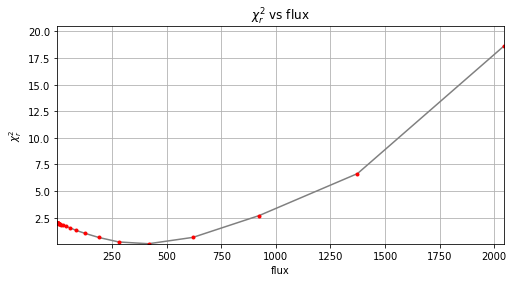

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 79, nfev: 197, chi2r: 0.047533046198255234
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.537, 239.907, 392.680) at 
          (X,Y)=(34.69, 23.58)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:15.031576
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [19]:
r_0, theta_0, f_0 = firstguess(cubefc, angs, psfn, ncomp=opt_npc_ann, planets_xy_coord=[xy_test], 
                               fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                               aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                               simplex=True, plot=True, verbose=True)

We see that using the optimal $n_{\rm pc}$ leads to a closer parameter estimates to the ground truth.

<font color=green> **Answer 5.1**: If relying on a 2D Gaussian fit, both the photometry and astrometry would be biased by self-subtraction and the negative side lobes. </font>

### 5.3.2. Planet subtraction

Let's use the values obtained with the simplex optimization to subtract the planet with the function `cube_planet_free`.

First we define a list with the parameters (r, theta, flux) is each companion that we obtained via the NegFC, in this case one:

In [20]:
plpar_fc = [(r_0[0], theta_0[0], f_0[0])]

Note: r_0, theta_0 and f_0 have the same length as the number of planet coordinates `planets_xy_coord` provided to `firstguess`. Here there is only one planet, so we take the zeroth index. The number of tuples in (i.e the length of) `plpar_fc` should match the number of planets.

In [21]:
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)

Let's double-check the fake companion was well removed by computing a PCA post-processed image:

In [22]:
from vip_hci.preproc import cube_derotate
from vip_hci.config import time_ini, timing
t0 = time_ini()
for i in range(100):
    fr_pca_emp = pca_annulus(cube_emp, angs, ncomp=opt_npc_ann, annulus_width=4*fwhm_naco, 
                             r_guess=rad_fc, imlib=imlib_rot, interpolation=interpolation)
    #cube_tmp = cube_derotate(cube_emp, angs, imlib=imlib_rot, interpolation=interpolation, edge_blend='')
timing(t0)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-28 00:33:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:07.310946
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame resulting of processing the planet-subtracted cube:

In [23]:
cropped_frame1 = frame_crop(final_ann_opt, cenxy=xy_test, size=15)

New shape: (15, 15)


In [24]:
cropped_frame2 = frame_crop(fr_pca_emp, cenxy=xy_test, size=15)

New shape: (15, 15)


Let's use both `'mode=surface'` and the default image mode of `plot_frames` to show the residuals in the vicinity of the companion:

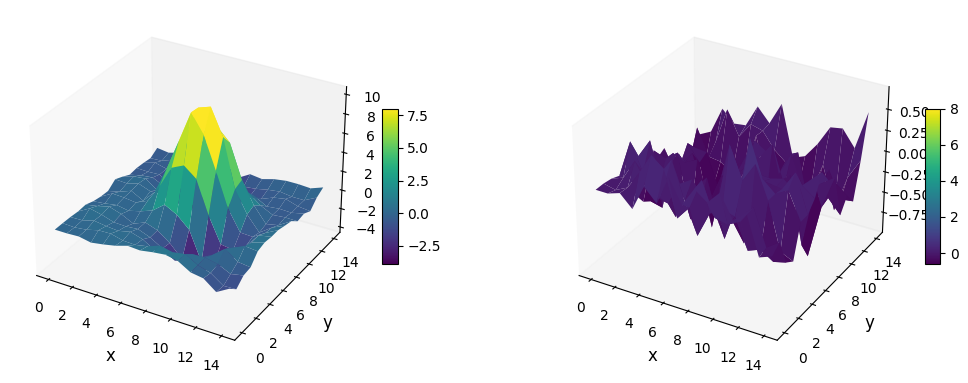

In [25]:
plot_frames((cropped_frame1, cropped_frame2), mode='surface', vmax=8)

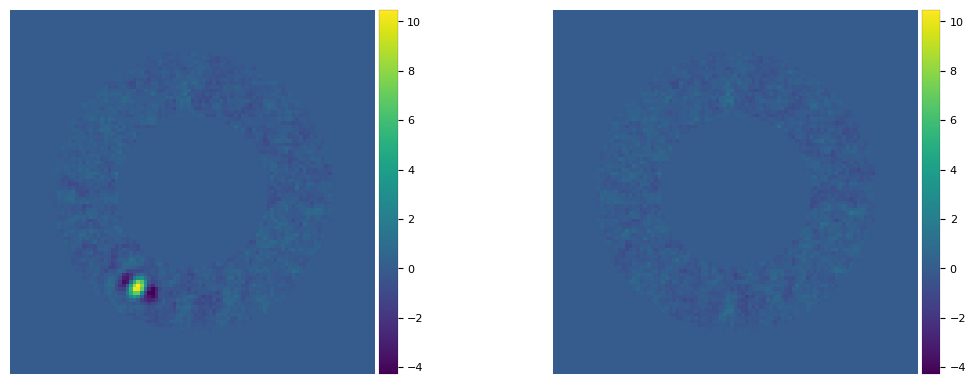

In [26]:
plot_frames((final_ann_opt, fr_pca_emp), vmin = float(np.amin(final_ann_opt)), 
            vmax= float(np.amax(final_ann_opt)), axis=False)

Not only the bright point-like signal is subtracted, but so are the negative side lobes. A subtraction not leaving any significant artifact/defect is a good sign that the inferred parameters are correct. However, keep in mind that even for slightly inaccurate parameters, the final image can still look relatively clean. Let's take for example the parameters inferred with non-optimal $n_{\rm pc}$: 

[(30.534749178951024, 239.97617468137406, 383.05503327816507)]


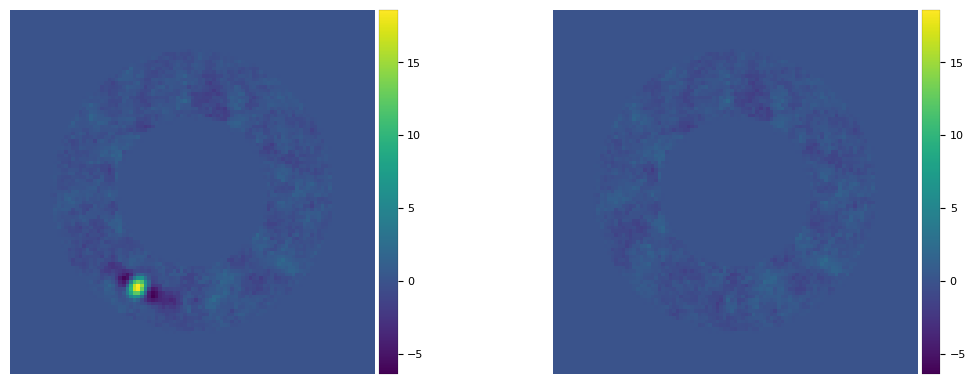

In [27]:
# planet parameters inferred from npc=5 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_lo[0], theta_lo[0], f_lo[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)
final_ann_5 = pca_annulus(cubefc, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp5 = pca_annulus(cube_emp, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_5, fr_pca_emp5), vmin = float(np.amin(final_ann_5)), 
            vmax= float(np.amax(final_ann_5)), axis=False)

[(30.18557073057306, 239.89702835629325, 424.15580033622734)]


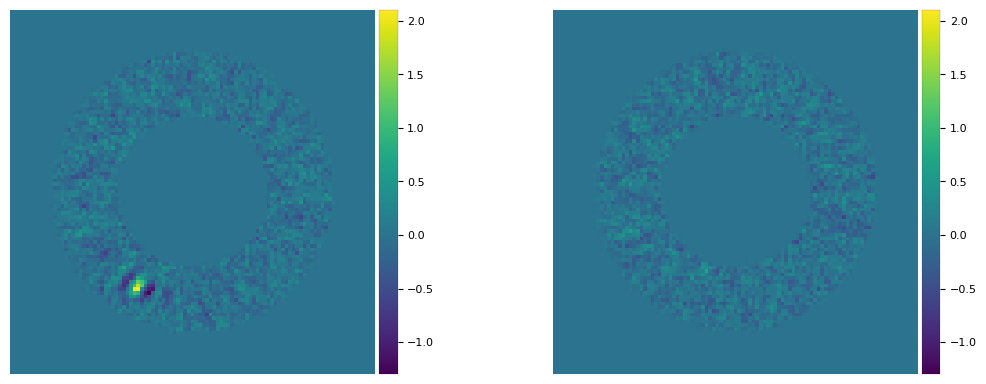

In [28]:
# parameters inferred from npc=25 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_hi[0], theta_hi[0], f_hi[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)
final_ann_25 = pca_annulus(cubefc, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp25 = pca_annulus(cube_emp, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_25, fr_pca_emp25), vmin = float(np.amin(final_ann_25)), 
            vmax= float(np.amax(final_ann_25)), axis=False)

Inaccurate parameters still leading to an apparently good removal of the companion brings the question of the uncertainties on each of the three parameters characterizing the companion. The next sections are dedicated to this question. 

### 5.3.3. NEGFC technique coupled with MCMC

#### 5.3.3.1. Running the MCMC sampler

MCMC is a more robust way of obtaining the flux and position. It samples the posterior distributions of the parameters and from them we can infer both the most likely parameter values and uncertainties on each parameter. The relevant function is `mcmc_negfc_sampling`, which can accept a number of parameters. Let's define them in the next few boxes:

Let's first define observation-related parameters, such as the non-coronagraphic psf, its FWHM and the pixel scale od the detector: 

In [29]:
obs_params = {'psfn': psfn,
              'fwhm': fwhm_naco}

In NEGFC, PCA in a single annulus is used by default to speed up the algorithm - although other algorithms can be used through the `algo` parameter. Let's set the $n_{\rm pc}$ to the optimal $n_{\rm pc}$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets). We set the width of the annulus on which PCA is performed (in pixels) with the `annulus_width` parameter. We also set a few other algorithm-related parameters in the following box:

In [30]:
annulus_width = 4*fwhm_naco

algo_params = {'algo': pca_annulus,
               'ncomp': opt_npc_ann,
               'annulus_width': annulus_width,
               'svd_mode': 'lapack',
               'imlib': imlib_rot, 
               'interpolation': interpolation}

The choice of log-likelihood expression to be used is determined by `mu_sigma` and `fm`. If the former is True (default; mu and sigma calculated automatically) or a tuple of 2 values, the following figure of merit will be used: $\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}$. Otherwise, the choice will be determined by `fm`: 'sum' for the sum of absolute residuals, or 'stddev' for the standard deviation of residuals (which can be useful if the point source is contained within a more extended signal).
`aperture_radius` is the radius of the aperture  (in `fwhm` units) in which the residual intensities $I_j$ are considered.

In [31]:
mu_sigma=True
aperture_radius=2

negfc_params = {'mu_sigma': mu_sigma,
                'aperture_radius': aperture_radius}

Parameter ``initial_state`` corresponds to the initial first estimation of the planets parameters (r, theta, flux). We set it to the result of the simplex optimization, obtained with optimal $n_{\rm pc}$. Note that the MCMC minimization can only run for one companion candidate at a time, hence the first dimension of init should always be 3 (not the number of planets, as opposed to `planets_xy_coord` in `firstguess`).

In [32]:
initial_state = np.array([r_0[0], theta_0[0], f_0[0]])

Beware that the MCMC procedure is a CPU intensive procedure and can take several hours when run properly on a standard laptop. We use the affine invariant sampler from `emcee` which can be run in parallel (`nproc` sets the number of CPUs to be used). At least 100 walkers are recommended for our MCMC chain, although both the number of walkers and iterations will depend on your dataset. 
For the sake of preventing this tutorial to take too long to run, we set the maximum number of iterations to 500, although feel free to significantly increase it in case of non-convergence.

In [33]:
nwalkers, itermin, itermax = (100, 200, 500)

mcmc_params = {'nwalkers': nwalkers,
               'niteration_min': itermin,
               'niteration_limit': itermax,
               'bounds': None,
               'nproc': 2}


Another update from Christiaens et al. (2021) is that the convergence can now be evaluated based on the auto-correlation time (see more details in the [documentation of `emcee`](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)), instead of the Gelman-Rubin test, which is inappropriate for non-independent samples (such as an MCMC chain).
We set the convergence test to the autocorrelation time based criterion using `conv_test='ac'` (instead of Gelman-Rubin 'gb'). We also set the autocorrelation criterion $N/\tau >= a_c$, where $N$ is the number of samples and $\tau$ the autocorrelation time, to `ac_c=50` (the value recommended in the `emcee` documentation). Finally, we set the number of consecutive times the criterion must be met to: `ac_count_thr=1`, and the maximum gap in number of steps between 2 checks of the convergence criterion to: `check_maxgap=50`. If the maximum number of iterations `niteration_limit` is large enough, the chain will stop upon meeting the convergence criterion (spoiler: it won't be the case here since we chose a small value for `niteration_limit`).

In [34]:
conv_test, ac_c, ac_count_thr, check_maxgap = ('ac', 50, 1, 50)

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr': ac_count_thr,
               'check_maxgap': check_maxgap}

Setting `bounds=None` does *not* mean no bounds are used for parameter exploration, but rather that they are set automatically to:

- $r \in [r_0-w_{ann}/2, r_0+w_{ann}/2]$, where $w_{ann}$ is the `annulus_width`,
- $\theta \in [\theta_0-\Delta {\rm rot}, \theta_0+\Delta {\rm rot}]$, where $\Delta {\rm rot}$ is the angle subtended by min(`aperture_radius`/2,`fwhm`) at $r_0$,
- $f \in [0.1*f_0, 2*f_0]$,

where ($r_0, \theta_0, f_0$) = `initial_state`.
If the `bounds` are provided manually (as a tuple of tuples), they will supersede the automatic setting above.

Now let's start the sampler. Note that this step is computer intensive and will take a long time to run (e.g. ~2h with 2 CPUs of the Apple M1 pro chip). Feel free to skip the next box if you do not wish to run the MCMC or can't run it in a reasonable time. The results are already saved as 'MCMC_results' in the 'datasets' folder and will be loaded in the subsequent boxes.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-28 00:33:31
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
        MCMC sampler for the NEGFC technique       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
The mean and stddev in the annulus at the radius of the companion (excluding the PA area directly adjacent to it) are -0.01 and 1.48 respectively.
Beginning emcee Ensemble sampler...
emcee Ensemble sampler successful

Start of the MCMC run ...
Step  |  Duration/step (sec)  |  Remaining Estimated Time (sec)
0		10.10945			5044.61530
1		8.59501			4280.31448
2		9.23678			4590.68115
3		9.98107			4950.61221
4		8.36696			4141.64273
5		10.31926			5097.71395
6		10.64876			5249.83967
7		9.20538			4529.04844
8		9.08590			4461.17592
9		9.18093			4498.65766
10		8.31188			4064.50932
11		9.61570			4692.46306
12		9.87977			4811.44799
13		6.76278			3286.71108
14		9.84969			4777.

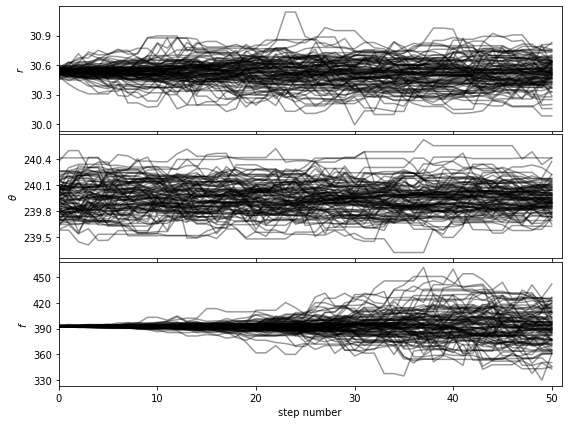

51		9.29144			4162.56691
52		9.26115			4139.73405
53		7.99408			3565.35790
54		8.85335			3939.73897
55		7.33565			3257.02993
56		7.49313			3319.45836
57		8.17327			3612.58667
58		8.61796			3800.52124
59		9.25932			4074.10036
60		8.03534			3527.51338
61		8.88423			3891.29230
62		7.14815			3123.74068
63		7.04014			3069.50104
64		8.60871			3744.79016
65		7.79305			3382.18196
66		10.26503			4444.75669
67		10.70231			4623.39792
68		8.59480			3704.35837
69		9.33293			4013.16162
70		9.14947			3925.12392
71		8.96319			3836.24532
72		10.72212			4578.34396
73		10.00098			4260.41663
74		9.38442			3988.37977
75		9.78499			4148.83618
76		8.79154			3718.82269
77		9.29137			3920.95941
78		7.66028			3224.97662
79		8.11904			3409.99848
80		9.28838			3891.83080
81		6.93091			2897.12080
82		13.31441			5552.11022
83		10.87820			4525.32995
84		9.90686			4111.34814
85		9.96833			4126.88655
86		12.03307			4969.65708
87		7.88585			3248.97185
88		8.63923			3550.72558
89		11.95215			4900.38068
90		10.45158			42

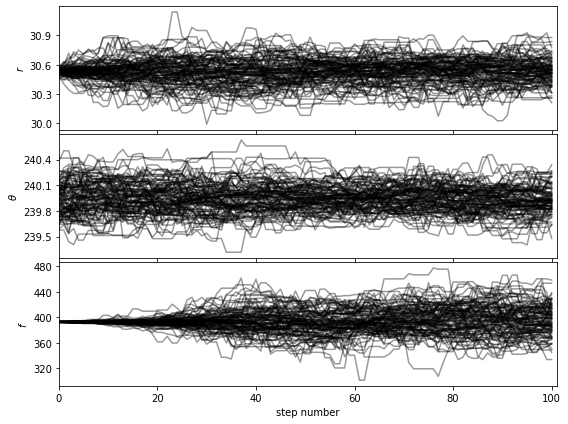

101		10.77369			4287.92862
102		8.47988			3366.51434
103		10.85674			4299.26864
104		12.28956			4854.37738
105		8.29112			3266.69970
106		10.25072			4028.53178
107		9.50976			3727.82435
108		10.06234			3934.37650
109		9.61207			3748.70652
110		9.43308			3669.46812
111		8.21768			3188.46178
112		7.79394			3016.25633
113		7.92713			3059.87334
114		10.70407			4121.06849
115		9.99814			3839.28461
116		9.55682			3660.26129
117		9.74418			3722.27752
118		9.07720			3458.41510
119		10.47448			3980.30316
120		11.45964			4343.20280
121		8.33819			3151.83431
122		7.91461			2983.80872
123		7.45436			2802.83786
124		7.31694			2743.85363
125		8.25310			3086.65865
126		8.31697			3102.22981
127		9.03882			3362.44253
128		7.42075			2753.09677
129		8.53951			3159.61759
130		7.75386			2861.17582
131		10.07451			3707.41931
132		12.88479			4728.71720
133		10.61477			3885.00728
134		8.02943			2930.74377
135		7.19724			2619.79645
136		10.01442			3635.23591
137		9.14353			3309.95858
138		9.29532			3355.60944


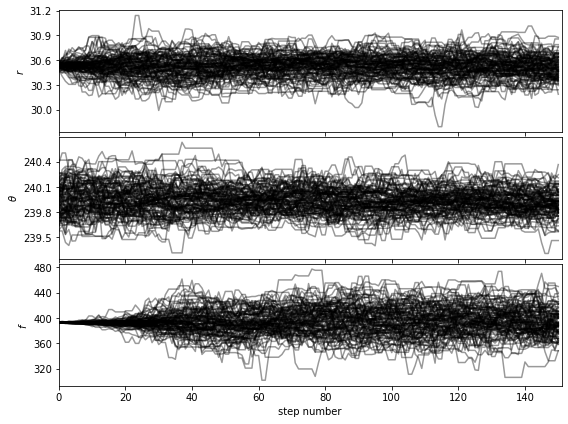

151		11.85715			4126.28855
152		10.27330			3564.83441
153		8.69749			3009.33327
154		10.46097			3609.03361
155		10.22275			3516.62497
156		9.44051			3238.09596
157		7.77553			2659.22955
158		7.57408			2582.76128
159		9.05472			3078.60650
160		9.97883			3382.82371
161		8.60485			2908.43998
162		12.19408			4109.40496
163		8.75393			2941.31981
164		8.96138			3002.06263
165		7.23993			2418.13762
166		7.62815			2540.17561
167		9.51193			3157.96043
168		9.69055			3207.57106
169		10.22173			3373.17156
170		11.49842			3782.97919
171		7.45919			2446.61399
172		8.93736			2922.51737
173		9.67367			3153.61772
174		10.38383			3374.74508
175		8.28143			2683.18332
176		7.56534			2443.60320
177		10.27129			3307.35474
178		7.60570			2441.43066
179		9.83686			3147.79584
180		8.21261			2619.82323
181		9.09388			2891.85257
182		8.44672			2677.61119
183		7.57279			2393.00196
184		7.78133			2451.11769
185		8.08092			2537.40762
186		9.51251			2977.41657
187		10.28054			3207.52754
188		10.34348			3216.82383
1

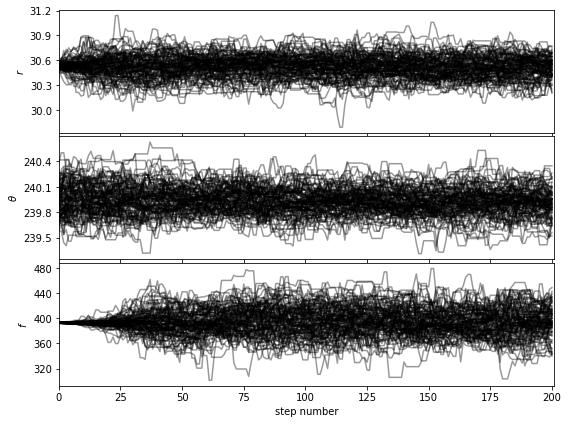

Auto-corr tau/N = [0.06356441 0.07371727 0.0634394 ]
tau/N <= 0.02 = [False False False] 

201		10.91381			3252.31657
202		8.53336			2534.40733
203		8.18553			2422.91747
204		8.84839			2610.27446
205		8.03984			2363.71325
206		9.44425			2767.16408
207		8.64659			2524.80545
208		11.67546			3397.55944
209		9.77834			2835.71715
210		9.30791			2689.98599
211		7.41808			2136.40819
212		8.30246			2382.80573
213		8.39670			2401.45620
214		9.27396			2643.07746
215		11.24141			3192.56129
216		8.89862			2518.30974
217		8.95071			2524.10107
218		7.11060			1998.07748
219		9.93015			2780.44116
220		8.56995			2391.01493
221		8.74098			2429.99105
222		8.80601			2439.26532
223		8.04258			2219.75236
224		6.30290			1733.29640
225		8.22424			2253.44121
226		11.31141			3088.01520
227		8.80249			2394.27674
228		8.80994			2387.49482
229		7.69983			2078.95410
230		8.37479			2252.81797
231		8.31673			2228.88498
232		7.72602			2062.84627
233		8.65473			2302.15898
234		9.15227			2425.35288
235		8.92052			2355.0

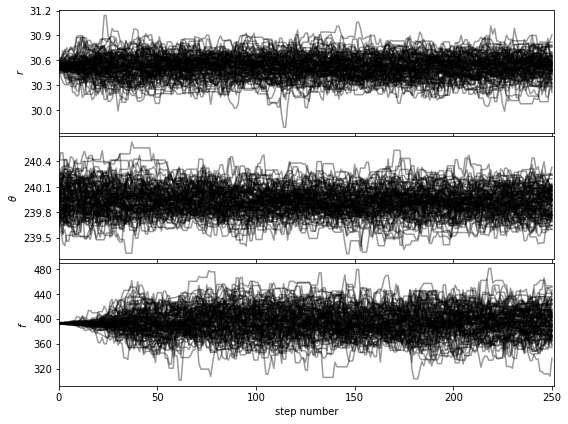

Auto-corr tau/N = [0.0592807  0.0630146  0.05966058]
tau/N <= 0.02 = [False False False] 

251		8.81909			2187.13506
252		7.55979			1867.26813
253		8.33129			2049.49660
254		9.62764			2358.77131
255		7.21419			1760.26138
256		11.36711			2762.20822
257		10.47625			2535.25202
258		10.89375			2625.39399
259		9.69913			2327.79192
260		8.80895			2105.33905
261		9.28379			2209.54154
262		10.35375			2453.83946
263		10.83460			2556.96513
264		9.60200			2256.46882
265		7.27149			1701.52819
266		6.28659			1464.77547
267		9.47194			2197.49031
268		6.69969			1547.62885
269		8.38455			1928.44650
270		8.25008			1889.26924
271		8.89654			2028.41158
272		9.75209			2213.72420
273		9.30713			2103.41183
274		8.65946			1948.37873
275		8.14558			1824.61082
276		10.44458			2329.14134
277		8.28262			1838.74208
278		9.89005			2185.70193
279		10.31914			2270.21080
280		8.06076			1765.30688
281		9.77015			2129.89314
282		8.72030			1892.30445
283		7.40165			1598.75662
284		9.88848			2126.02406
285		6.63962			142

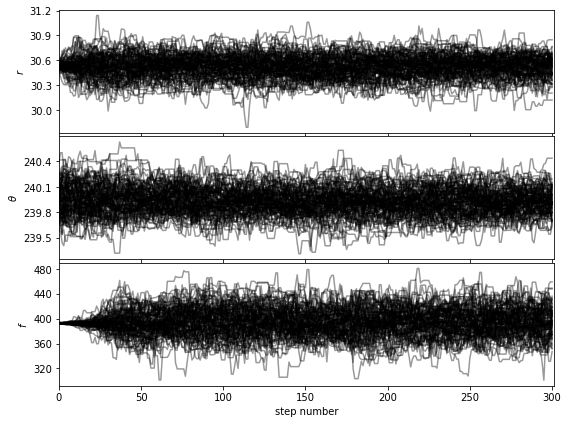

Auto-corr tau/N = [0.05105766 0.05682598 0.05691353]
tau/N <= 0.02 = [False False False] 

301		10.50783			2080.55074
302		8.91701			1756.65117
303		7.19726			1410.66296
304		9.03491			1761.80842
305		11.26681			2185.76172
306		10.16506			1961.85600
307		9.63789			1850.47526
308		8.17775			1561.95120
309		10.42452			1980.65823
310		8.93627			1688.95560
311		8.25273			1551.51324
312		7.57510			1416.54407
313		8.91973			1659.06922
314		9.83180			1818.88337
315		8.43943			1552.85457
316		9.29831			1701.59146
317		9.84794			1792.32472
318		8.75815			1585.22569
319		7.58530			1365.35364
320		9.79518			1753.33740
321		9.61667			1711.76797
322		7.93690			1404.83077
323		8.85610			1558.67413
324		10.51946			1840.90550
325		9.09025			1581.70420
326		6.48085			1121.18705
327		7.28479			1252.98457
328		7.19256			1229.92827
329		9.00688			1531.16926
330		7.78543			1315.73733
331		6.73496			1131.47378
332		8.63709			1442.39420
333		8.78618			1458.50588
334		6.76996			1117.04356
335		9.82556			1611.

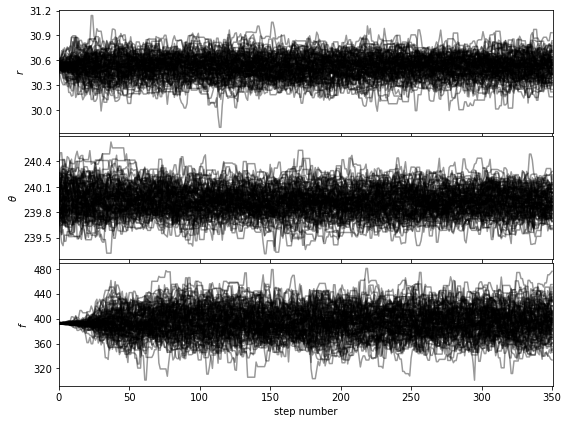

Auto-corr tau/N = [0.04751617 0.05325121 0.05131867]
tau/N <= 0.02 = [False False False] 

351		10.17011			1505.17687
352		10.04502			1476.61809
353		8.42501			1230.05117
354		9.74155			1412.52547
355		9.01412			1298.03299
356		8.64502			1236.23800
357		7.69681			1092.94645
358		8.70197			1226.97847
359		10.23048			1432.26762
360		8.64974			1202.31344
361		8.19243			1130.55603
362		8.95605			1226.97953
363		7.93448			1079.08969
364		10.85785			1465.80989
365		10.43182			1397.86455
366		9.19154			1222.47522
367		9.79168			1292.50189
368		8.10697			1062.01255
369		9.34746			1215.16980
370		8.89344			1147.25428
371		9.62413			1231.88877
372		7.10591			902.45082
373		10.48143			1320.66043
374		7.14191			892.73838
375		7.74147			959.94228
376		10.55005			1297.65664
377		8.68175			1059.17362
378		7.99967			967.95995
379		8.37678			1005.21336
380		8.81326			1048.77853
381		10.18487			1201.81490
382		9.56377			1118.96156
383		7.42292			861.05918
384		8.94624			1028.81737
385		8.54697			974.354

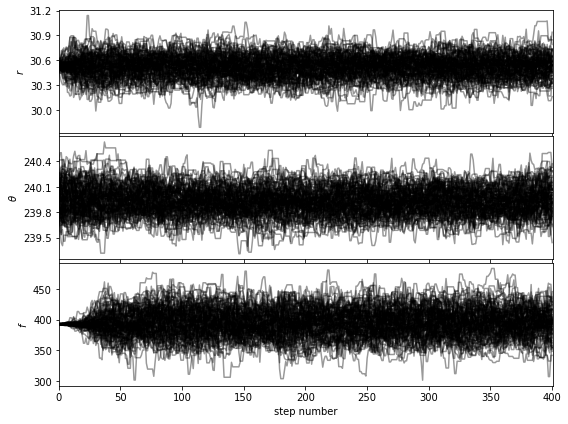

Auto-corr tau/N = [0.04515981 0.05132334 0.04869306]
tau/N <= 0.02 = [False False False] 

401		9.52498			933.44853
402		8.47651			822.22147
403		9.91155			951.50928
404		8.80194			836.18468
405		7.43051			698.46775
406		8.86156			824.12545
407		9.54843			878.45584
408		6.97089			634.35145
409		8.55515			769.96377
410		7.54874			671.83795
411		9.53012			838.65047
412		10.17825			885.50749
413		9.70523			834.64987
414		8.03749			683.18623
415		9.98110			838.41206
416		9.51999			790.15950
417		8.60412			705.53784
418		7.10210			575.27010
419		8.15146			652.11720
420		9.33509			737.47195
421		9.58290			747.46589
422		10.75539			828.16511
423		8.23931			626.18756
424		10.36109			777.08168
425		9.14241			676.53849
426		10.89273			795.16922
427		9.38809			675.94255
428		8.72504			619.47784
429		9.25670			647.96893
430		9.63215			664.61863
431		8.74688			594.78770
432		8.95053			599.68531
433		8.45606			558.10003
434		9.21543			599.00321
435		8.98519			575.05248
436		9.75706			614.69459
437		

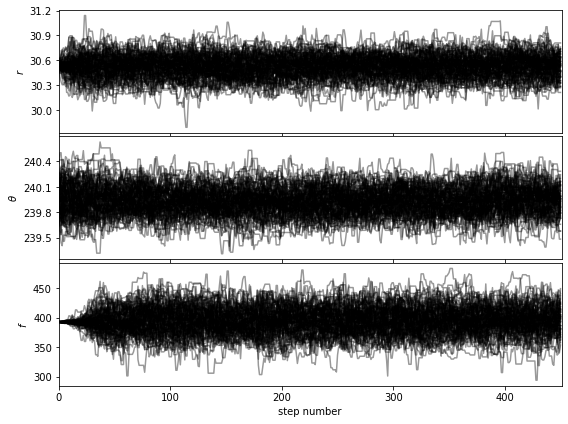

Auto-corr tau/N = [0.04290313 0.04919929 0.04686504]
tau/N <= 0.02 = [False False False] 

451		10.20455			489.81830
452		8.41949			395.71598
453		9.20051			423.22351
454		8.43066			379.37957
455		9.56404			420.81767
456		11.04692			475.01735
457		8.64497			363.08887
458		8.63729			354.12885
459		8.03785			321.51404
460		9.02012			351.78472
461		6.14168			233.38365
462		9.83875			364.03375
463		9.72507			350.10252
464		9.51933			333.17665
465		8.75781			297.76544
466		7.78756			256.98951
467		9.05385			289.72320
468		9.77690			303.08405
469		7.83829			235.14873
470		8.41010			243.89302
471		8.24399			230.83164
472		10.81160			291.91325
473		6.46885			168.19023
474		8.10548			202.63700
475		9.35324			224.47786
476		9.51167			218.76841
477		8.32933			183.24526
478		9.55090			200.56880
479		12.05228			241.04564
480		11.02020			209.38376
481		10.46389			188.35004
482		7.68866			130.70722
483		7.79594			124.73506
484		9.08313			136.24695
485		10.63844			148.93817
486		9.10195			118.32540
48

In [35]:
chain = mcmc_negfc_sampling(cubefc, angs, **obs_params, **algo_params, **negfc_params, 
                            initial_state=initial_state, **mcmc_params, **conv_params,
                            display=True, verbosity=2, save=False, output_dir='./')

If you ran the previous box and wish to write your results, set `write=True` in the next box. This will pickle the MCMC chain.

In [36]:
write=False

if write:
    import pickle
    output = {'chain':chain}
    with open('../datasets/my_MCMC_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Note that an alternative to the box above, is to provide `output_dir` in the call to `mcmc_negfc_sampling` and set `save` to True. This will save the results as a pickle including additional keys: apart from 'chain', it will also save 'input_parameters', 'AR' (acceptance ratio), and 'lnprobability'.

Pickled results can be loaded from disk like this:

In [37]:
import pickle
with open('../datasets/MCMC_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    mcmc_result = myPickler.load()

print(mcmc_result.keys())
chain = mcmc_result['chain']

dict_keys(['chain', 'input_parameters', 'AR', 'lnprobability'])


The most accurate approach would involve setting a large enough maximum number of iterations and using FFT-based rotation for PCA. The latter in particular, may change a bit the most likely parameter values given the better flux conservation. However, these changes would involve over ~3 orders of magnitude longer calculation time. It is therefore intractable for a personal laptop and not shown in this notebook. If you have access to a supercomputer feel free to adopt these changes though. The results after 500 iterations are nonetheless good enough for illustrative purpose:

#### 5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots 

Let's first check that the walk plots look ok:

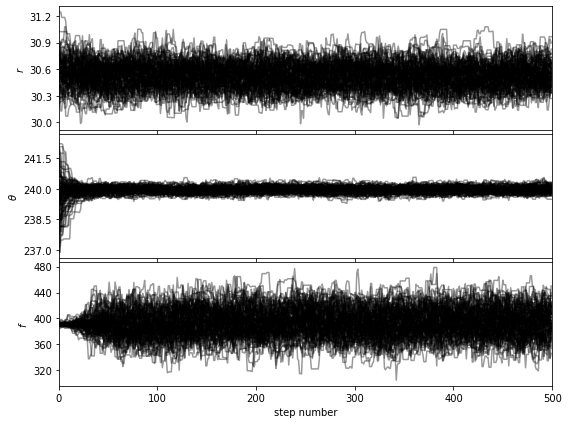

In [38]:
show_walk_plot(chain)

Then based on the walk plot, let's burn-in the first 30% of the chain, to calculate the corner plots:

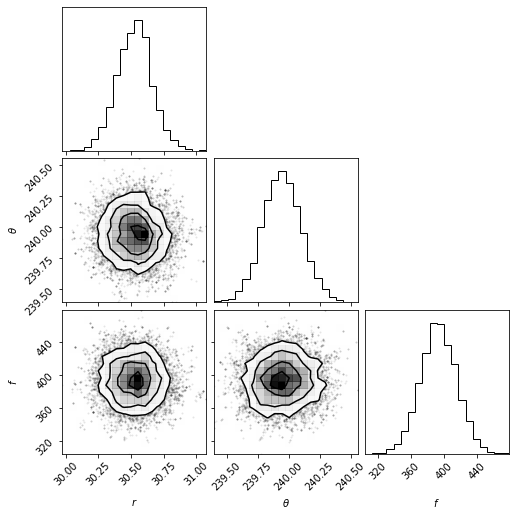

In [39]:
burnin = 0.3
burned_chain = chain[:, int(chain.shape[1]//(1/burnin)):, :]
show_corner_plot(burned_chain)

For the purpose of this tutorial and to limit computation time we set the maximum number of iterations to 500 for 100 walkers. The look of the corner plots may improve with more samples (i.e. higher number of iterations, for a given burn-in ratio). This can be tested by setting the max. number of iterations arbitrarily high for the autocorrelation-time convergence criterion to be met.

#### 5.3.3.3. Highly probable values and confidence intervals 

Now let's determine the most highly probable value for each model parameter, as well as the 1-sigma confidence interval. For this, let's first flatten the chains:

In [40]:
isamples_flat = chain[:, int(chain.shape[1]//(1/burnin)):, :].reshape((-1,3))

Then use the `confidence` function:

percentage for r: 69.79202279202278%
percentage for theta: 69.02279202279202%
percentage for f: 68.94017094017094%


Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
f: 390.7650582608513 [-20.054061636888093,25.285555976945886]


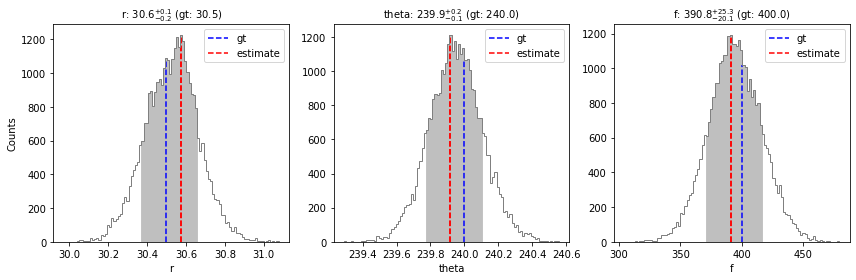

In [41]:
val_max, conf = confidence(isamples_flat, cfd=68, gaussian_fit=False, verbose=True, save=False, 
                           gt=gt, ndig=1, title=True)

Using the `confidence` function with the `gaussian_fit=True` option, it is possible to fit a Gaussian to the posterior distribution of each parameter, and infer associated uncertainty values.

percentage for r: 69.79202279202278%
percentage for theta: 69.02279202279202%
percentage for f: 68.94017094017094%


Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
f: 390.7650582608513 [-20.054061636888093,25.285555976945886]

Gaussian fit results:
r: 30.525747462344565 +-0.13676103149725966
theta: 239.94793373875024 +-0.15744912409220196
f: 394.1338634773366 +-21.669634439677626


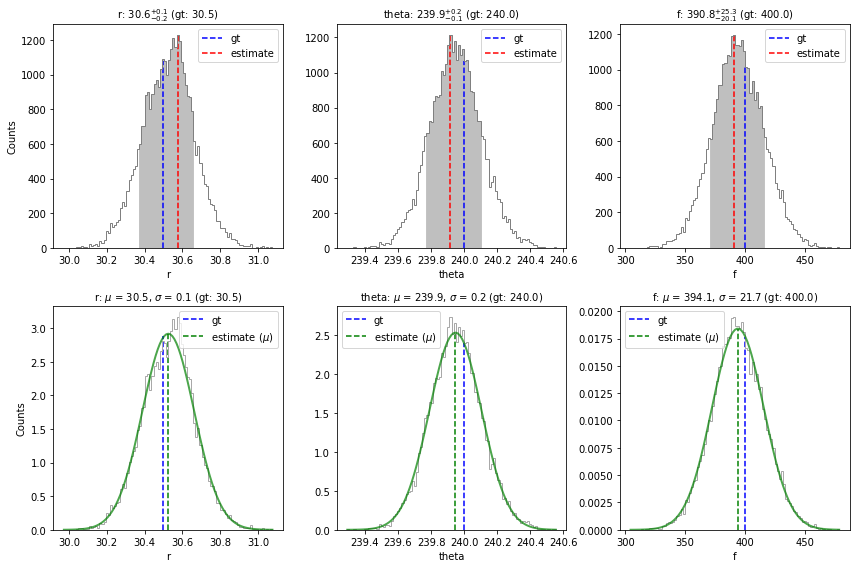

In [42]:
mu, sigma = confidence(isamples_flat, cfd=68, gaussian_fit=True, verbose=True, save=False, 
                       gt=gt, ndig=1, title=True)

It is recommended to report the results as confidence intervals (i.e. with possibly asymmetric uncertainties) as long as the bin interval is small enough. Here, we also fitted the residual posterior distribution of each parameter to a Gaussian distribution (this shape is the expected one if the noise has been well whitened, but is not necessarily guaranteed at all separations depending on the adopted $n_{\rm pc}$). In case, these distributions look Gaussian, the inferred $\sigma$ value may be a more accurate uncertainty value for the different parameters.

We can see that the confidence intervals inferred by NEGFC for the different parameters encompass the ground truth values used for injection (in particular for the flux). 

Note that depending on your choice of `mu_sigma`, you may have to calculate separately another source of uncertainty. Indeed, with the original expression for $\chi^2$ (Wertz et al. 2017; `mu_sigma=False`), only the uncertainty associated to *photon noise* was reflected in the MCMC results. With the new expression (`mu_sigma=True`), the $\chi^2$ expression also takes into account the *residual speckle noise* at the radial separation of the companion candidate. Our tests suggest that similar final uncertainties can be obtained in either of these 2 ways:  

- the uncertainties obtained with MCMC when setting `mu_sigma=True`;  
- the uncertainties obtained by combining quadratically the uncertainties obtained with MCMC (setting `mu_sigma=False` and `fm = 'sum'`), and the residual speckle uncertainties inferred as in [Sec. 5.3.4](#5.3.4.-Residual-speckle-uncertainty) (Wertz et al. 2017).  

### 5.3.4. Residual speckle uncertainty

**Only needed if using `mu_sigma=False` in your call to mcmc_negfc_sampling!**

Residual speckle noise can also bias the best parameter estimates found for the companion (if not taken into account in the MCMC).
To evaluate the uncertainty associated to this additional source of noise, it is recommended to inject a large number of fake companions at the same radius and flux as estimated for the true companion but different azimuths, and then estimate their parameters using simplex-NEGFC. The distribution of differences with respect to injected parameters can then give us an idea of the *residual speckle noise uncertainty*. This is done in VIP with the `speckle_noise_uncertainty` function (see also Sec. 3.3 in Wertz et al. 2017 for more details).

Let's use the planet parameters inferred by the MCMC-NEGFC algorithm:

In [43]:
pl_par = (val_max['r'],val_max['theta'],val_max['f'])
pl_par

(30.57489764243517, 239.91771004343246, 390.7650582608513)


#######################################################
###            SPECKLE NOISE DETERMINATION          ###
#######################################################

Number of steps: 360

Process is running for angle: 0.00
Process is running for angle: 45.00
Process is running for angle: 1.00
Process is running for angle: 46.00
Process is running for angle: 2.00
Process is running for angle: 47.00
Process is running for angle: 48.00
Process is running for angle: 3.00
Process is running for angle: 49.00
Process is running for angle: 4.00
Process is running for angle: 50.00
Process is running for angle: 5.00
Process is running for angle: 6.00
Process is running for angle: 51.00
Process is running for angle: 7.00
Process is running for angle: 52.00
Process is running for angle: 8.00
Process is running for angle: 53.00
Process is running for angle: 9.00
Process is running for angle: 54.00
Process is running for angle: 10.00
Process is running for angle: 11.00
Process is running for ang

Process is running for angle: 243.00
Process is running for angle: 201.00
Process is running for angle: 244.00
Process is running for angle: 202.00
Process is running for angle: 245.00
Process is running for angle: 203.00
Process is running for angle: 246.00
Process is running for angle: 204.00
Process is running for angle: 247.00
Process is running for angle: 205.00
Process is running for angle: 248.00
Process is running for angle: 206.00
Process is running for angle: 249.00
Process is running for angle: 207.00
Process is running for angle: 250.00
Process is running for angle: 208.00
Process is running for angle: 251.00
Process is running for angle: 209.00
Process is running for angle: 252.00
Process is running for angle: 210.00
Process is running for angle: 211.00
Process is running for angle: 253.00
Process is running for angle: 254.00
Process is running for angle: 212.00
Process is running for angle: 255.00
Process is running for angle: 213.00
Process is running for angle: 256.00
P



Confidence intervals:
r: -0.023983626399063998 [-0.07150872806551235,0.07903596259872418]
theta: 0.0016742416929815505 [-0.07316407829144425,0.07316407829144425]
f: -0.6406462829482883 [-10.48410612354823,10.48410612354823]

Gaussian fit results:
r: -0.0053606453339957545 +-0.052782215383237525
theta: -0.0007854748231031359 +-0.0726802096480306
f: 0.0002356324904697418 +-10.59768605206163


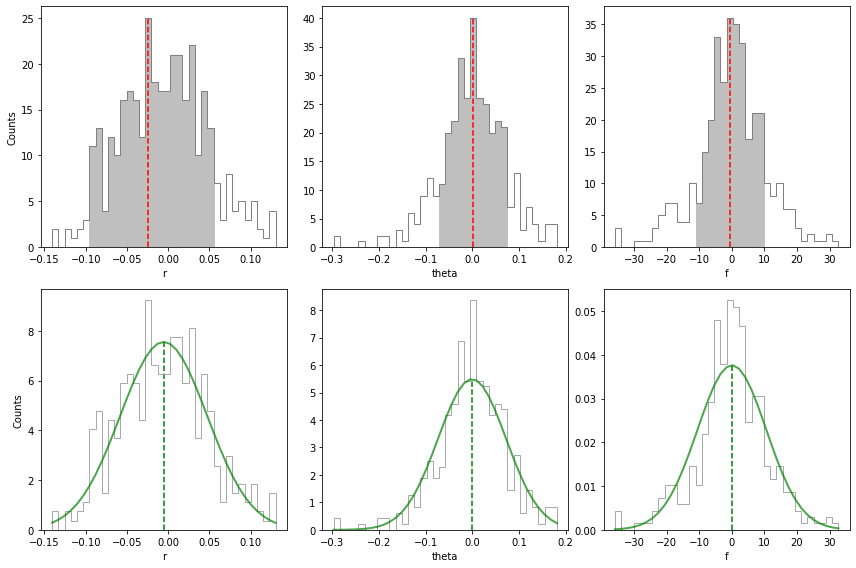

In [44]:
algo_options={'ncomp':opt_npc_ann, 'annulus_width':4*fwhm_naco, 'imlib':imlib_rot, 
              'interpolation':interpolation}
speckle_res = speckle_noise_uncertainty(cubefc, pl_par, np.linspace(0,359,360), angs, pca_annulus, 
                                        psfn, fwhm_naco, aperture_radius=2, fmerit='sum', 
                                        algo_options=algo_options, transmission=None, mu_sigma=None, 
                                        wedge=None, weights=None, force_rPA=False, nproc=2, 
                                        simplex_options=None, bins=None, save=False, output=None, 
                                        verbose=True, full_output=True, plot=True)

Again, if you wish to write the result (to avoid having to run the previous box again), just set `write=True`. This will pickle the result:

In [45]:
write=False

if write:
    output = {'speckle_res':speckle_res}
    with open('../datasets/my_speckle_residuals_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Load pickled results from disk:

In [46]:
with open('../datasets/speckle_residuals_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    sp_unc_result = myPickler.load()

print(sp_unc_result.keys())

speckle_res = sp_unc_result['speckle_res']
sp_unc, mean_dev, p_simplex, offset, chi2, nit, success = speckle_res

dict_keys(['speckle_res'])


The speckle uncertainty associated to each parameter is contained in `sp_unc` which corresponds to the 1$\sigma$ width of a Gaussian distribution fitted to the `offset` distribution (i.e. the differences with respect to injected ground truths):

In [47]:
sp_unc

array([ 0.05350939,  0.07376633, 10.64773837])

For comparison, the uncertainties found by the MCMC procedure were:

In [48]:
sigma

array([ 0.13676103,  0.15744912, 21.66963444])

### 5.3.5. Final uncertainties

The final uncertainties on the planet parameters should include both **statistical** and **systematic** uncertainties. 
The former include both the *photon noise* and *residual speckle noise* uncertainties discussed above. 
The latter include both the uncertainty on the *star location* (which may be non-negligible when using a coronagraph) and *instrumental calibration errors*, including:

- the uncertainty on the plate scale (for $r$, when converting to angular separation) - note that it is proportional to the radial separation itself;
- the uncertainty on the PA of true north (for $\theta$).

The uncertainty on the star location is of the order of 0.3px in individual NACO+AGPM images (this is the typical precision by manual recentering during the observation). Given the shift plots in `Tutorial 2`, it appears the autocorrelation timescale is of the order of ~5 frames. Therefore, considering that there are 61 frames in the datacube, the uncertainty on the star location in the final combined image must be roughly:

In [49]:
cen_unc_indiv = 0.3 #px
cen_unc = cen_unc_indiv/np.sqrt(61/5) #px
cen_unc

0.08588975014708022

The latter can be translated into an uncertainty on $\theta$ by division by the radial separation of the companion. The stellar centering uncertainties on each planet parameter can thus be expressed as:

In [50]:
star_unc = np.array([cen_unc*pxscale_naco, 
                     np.rad2deg(cen_unc/val_max['r']), 
                     0]) # uncertainty on each of the 3 parameters due to stellar centering

where the multiplication by `pxscale_naco` has converted the radial separation in arcsec.

For the instrumental calibration errors, we adopt the values quoted in Absil et al. (2013). Note that the uncertainty related to the plate scale is directly proportional to the radial separation of the companion.

In [51]:
dr_unc = 0.00004 # plate scale uncertainty in arcsec per px
tn_unc = 0.09    # deg
syst_unc = np.array([val_max['r']*dr_unc, 
                     tn_unc, 
                     0])

The final uncertainties are then the different sources of uncertainty added quadratically - after conversion of the radial separation to arcsec:

In [52]:
sigma[0] *= pxscale_naco
sp_unc[0] *= pxscale_naco

if mu_sigma:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(star_unc,2) + np.power(syst_unc,2))
else:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(sp_unc,2) + np.power(star_unc,2) + np.power(syst_unc,2))

In [53]:
msg = "The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(val_max['r']*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 val_max['theta'], final_unc[1], theta_fc,
                 val_max['f'], final_unc[2], flux_fc))

The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 831.33+-4.56 mas (GT: 829.29 mas), 
PA = 239.92+-0.24 deg (GT: 240.00 deg) 
f = 390.77+-21.67 ADUs (GT: 400.00 ADUs)


Let's consider the Gaussian fit instead:

In [54]:
msg = "Considering a Gaussian fit to the posterior distributions, the final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(mu[0]*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 mu[1], final_unc[1], theta_fc,
                 mu[2], final_unc[2], flux_fc))

Considering a Gaussian fit to the posterior distributions, the final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 830.00+-4.56 mas (GT: 829.29 mas), 
PA = 239.95+-0.24 deg (GT: 240.00 deg) 
f = 394.13+-21.67 ADUs (GT: 400.00 ADUs)
